In [13]:
import sys, os
sys.path.insert(0, '/home/storage/hans/jax_reco_new/')

import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [29]:
from lib.cgamma import c_multi_gamma_prob
from lib.cgamma_biweight import c_multi_gamma_biweight_prob
from lib.network import get_network_eval_fn
from lib.trafos import transform_network_outputs, transform_network_inputs
from lib.plotting import adjust_plot_1d

eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco/data/network')

In [39]:
closest_approach_dist = 20.0
closest_approach_rho = 0.0
closest_approach_z = -210
track_zenith = 0.0
track_azimuth = 0.0

x = jnp.array([closest_approach_dist,
                          closest_approach_rho,
                          closest_approach_z,
                          track_zenith,
                          track_azimuth])

x_prime = transform_network_inputs(x)
y_pred = eval_network(x_prime)
logits, av, bv = transform_network_outputs(y_pred)
mix_probs = jax.nn.softmax(logits)

In [40]:
c_multi_gamma_prob_v = jax.vmap(c_multi_gamma_prob, (0, None, None, None, None, None), 0)
c_multi_gamma_biweight_prob_v = jax.vmap(c_multi_gamma_biweight_prob, (0, None, None, None, None), 0)

In [41]:
gm = tfd.MixtureSameFamily(
          mixture_distribution=tfd.Categorical(
              logits=logits
              ),
          components_distribution=tfd.Gamma(
            concentration=av,    
            rate=bv,
            force_probs_to_zero_outside_support=True
              )
    )

In [46]:
xvals = np.linspace(-10, 100, 1000)
yvals_multi_gamma = gm.prob(xvals)

sigma=3.0
yvals_c_multi_gamma = c_multi_gamma_prob_v(xvals, mix_probs, av, bv, sigma, 0.1)
yvals_c_multi_gamma_biweight = c_multi_gamma_biweight_prob_v(xvals, mix_probs, av, bv, sigma)

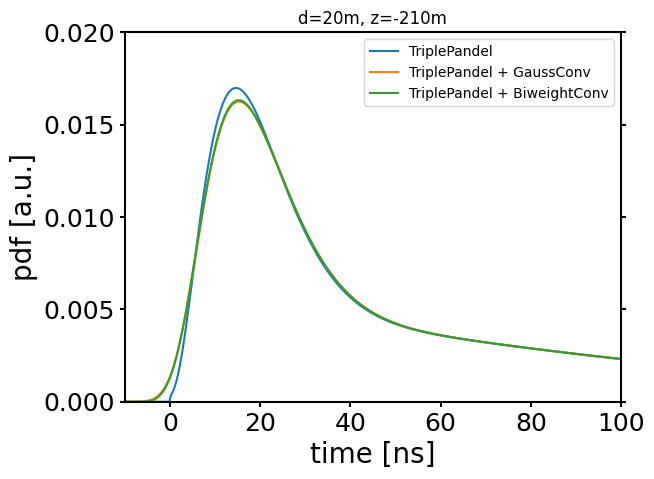

In [47]:
fig, ax = plt.subplots()

ax.plot(xvals, yvals_multi_gamma, label='TriplePandel')
ax.plot(xvals, yvals_c_multi_gamma, label='TriplePandel + GaussConv')
ax.plot(xvals, yvals_c_multi_gamma_biweight, label='TriplePandel + BiweightConv')

plot_args = {'xlabel':'time [ns]', 
                 'ylabel':'pdf [a.u.]', 
                 'xlim':[-10, 100], 
                 'ylim':[0.0, 0.02]}

adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.title(f"d={closest_approach_dist:.0f}m, z={closest_approach_z:.0f}m")
plt.show()
